# Tutorial: Calibrating Hinode EIS Data Using EISPAC in Python

This tutorial demonstrates how to calibrate Hinode EUV Imaging Spectrometer (EIS) data using the EISPAC library in Python. We will explore two calibration methods:

1. Warren et al. 2014 calibration
2. Del Zanna et al. 2023 calibration (currently in review)

The purpose of this tutorial is to guide you through the process of applying these calibrations to EIS data that has been processed using EISPAC. By the end of this tutorial, you will be able to:

- Read and fit EIS data using EISPAC
- Retrieve and apply the Warren et al. 2014 and Del Zanna et al. 2023 calibration functions
- Compare the calibrated intensity maps with the default EISPAC preflight calibration
- Compare the calibration results between IDL and Python implementations


In [101]:
# Import necessary libraries
import scipy.io as io
import eispac
import numpy as np 
import os 
import matplotlib.pyplot as plt
from scipy.io import readsav
import re

## Set data directory and file name
- Define the directory and file name of the EIS data to be analyzed
- Construct the full file path by joining the directory and file name


In [112]:
# Set the data directory and file name
data_dir = '/Users/andysh.to/Script/Python_Script/spice/SO_EIS_data'
data_name = 'eis_20230327_131642.data.h5'
data_filepath = os.path.join(data_dir,data_name)

## Read Fe XIII templates
- Read in a custom template for Fe XIII 203.83 Å using the `eispac.read_template()` function (See Fe XIII density tutorial)
- The custom template file is assumed to be in the current directory
- Create a directory named 'fit_res' to store the fit results, if it doesn't already exist


In [113]:
## Read that file 
# Fe XIII 203.83 Template
my_template_filename_203 = 'my_Fe_XIII_template-3c.h5'

# Read the custom Fe XIII 203.83 Å template file
FeXIII_203_tmplt = eispac.read_template(my_template_filename_203)

# Create the directory 'fit_res' if it doesn't exist
os.makedirs('fit_res', exist_ok=True)

## Read spectral window and fit the data
- Read the Fe XIII templates
 - Read the spectral window into an EISCube using `eispac.read_cube()`
 - Fit the data using `eispac.fit_spectra()` and save the results to disk using `eispac.save_fit()`
 - Append the fit results to the `all_fits` list


In [104]:
all_fits=[] # Initialize a list to store all fit results

for template in [FeXIII_203_tmplt]:
    data_cube = eispac.read_cube(data_filepath, template.central_wave,
                                  apply_radcal=True) 
    
    # Fit the data, then save it to disk
    save_dir = 'fit_res/'
    fit_res = eispac.fit_spectra(data_cube, template, ncpu='max')
    fit_res.fit['int'] = fit_res.shift2wave(fit_res.fit['int'],wave=195.119)
    save_filepaths = eispac.save_fit(fit_res, save_dir=save_dir)
    all_fits.append(fit_res)

Data file,
   /Users/andysh.to/Script/Python_Script/spice/SO_EIS_data/eis_20230327_131642.data.h5
Header file,
   /Users/andysh.to/Script/Python_Script/spice/SO_EIS_data/eis_20230327_131642.head.h5
Found a wavelength 203.78 [Angstroms] in window 12
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
 + computing fits for 83 exposures, each with 512 spectra
 + running mpfit on 12 cores (of 12)
 + working on exposure 074

Finished computing fits!
   runtime : 0:00:33.304292
   42496 spectra fit without issues
   0 spectra have < 10 good data points
   0 spectra have bad or invalid parameters
Saving EIS fit results...
   Directory: fit_res
   Filenames: eis_20230327_131642.fe_13_203_710.3c-0.fit.h5
              eis_20230327_131642.fe_13_203_800.3c-1.fit.h5
              eis_20230327_131642.fe_13_203_830.3c-2.fit.h5


## Retrieve Calibration Functions
- Import the necessary calibration functions from the `eis_calibration` module (Please download this folder)
- The `calib_2014` functions is from the 2014 calibration
- The `calib_2023` function is from the 2023 calibration
- Also import `sunpy.map` for creating map objects


In [116]:
# Import calibration functions and sunpy.map

from eis_calibration.eis_calib_2014 import calib_2014 # preflight effective area and calibrated 2014 effective area
from eis_calibration.eis_calib_2023 import calib_2023 # 2023 effective area
import sunpy.map

- Read the default intensity map produced by EISPAC
- The intensity map is obtained from the fit result in the `all_fits` list


In [117]:
# Get the default intensity map from the fit results
int_203 = all_fits[0].get_map(2,'int')

INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


### 2014 calibration to the intensity map
- This cancels the preflight calibration and applies the corresponding calibration from Warren et al. 2014 paper

In [107]:
# Apply the 2014 calibration to the intensity map

int_203_calibed_2014 = calib_2014(int_203)

### 2023 calibration to the intensity map
- Similar to the 2014 calibration, but using the `calib_2023` function from the 2023 calibration


In [108]:
# ### 2023 calibration to the intensity map

int_203_calibed_2023 = calib_2023(int_203)

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


Text(0.5, 1.0, 'Del Zanna et al. 2023 Calibration')

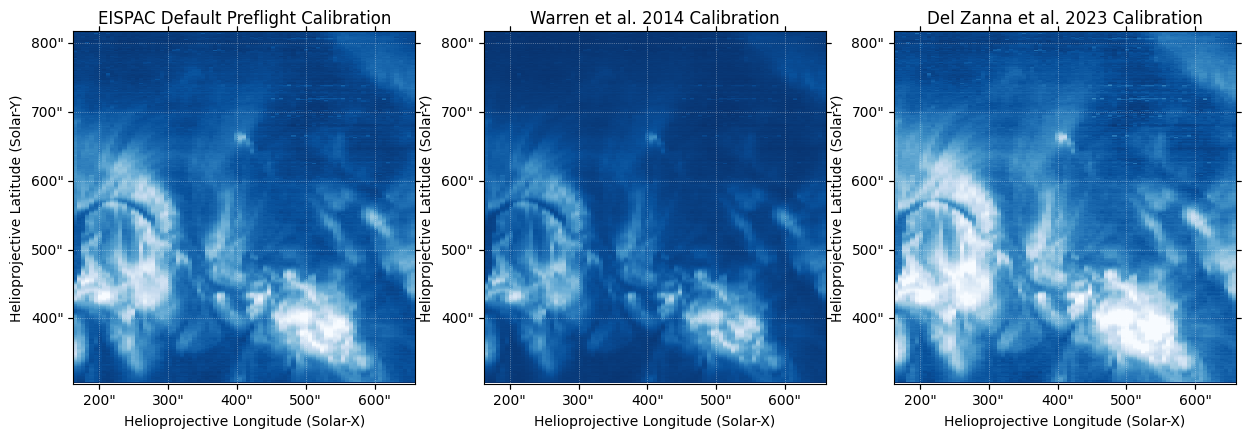

In [109]:
# Plot the original and calibrated intensity maps side by side for comparison

fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 3, 1, projection=int_203)
ax2 = fig.add_subplot(1, 3, 2, projection=int_203_calibed_2014)
ax3 = fig.add_subplot(1, 3, 3, projection=int_203_calibed_2023)

int_203.plot(axes=ax1, vmin=0,vmax=3500)
int_203_calibed_2014.plot(axes=ax2, vmin=0,vmax=3500)
int_203_calibed_2023.plot(axes=ax3, vmin=0,vmax=3500)

ax1.set_title('EISPAC Default Preflight Calibration')
ax2.set_title('Warren et al. 2014 Calibration')
ax3.set_title('Del Zanna et al. 2023 Calibration')

# Test against IDL Calibrations

- Calibrations in IDL vs Python
- Here we use the standard Fe XVI 262.98 line, this line is among the lines that are most affected by calibration. And only a single gaussian - minimizes error from fitting

In [26]:
# Read the Fe XVI 262.98 template and fit the data
template_name = 'fe_16_262_984.1c.template.h5'
template = eispac.read_template(eispac.data.get_fit_template_filepath(template_name))

data_cube = eispac.read_cube(data_filepath, template.central_wave,
                              apply_radcal=True) 

# Fit the data, then save it to disk
save_dir = 'fit_res/'
fit_res_fe16 = eispac.fit_spectra(data_cube, template, ncpu='max')
fit_res_fe16.fit['int'] = fit_res_fe16.shift2wave(fit_res_fe16.fit['int'],wave=195.119)
save_filepaths = eispac.save_fit(fit_res_fe16, save_dir=save_dir)

Data file,
   /Users/andysh.to/Script/Python_Script/spice/SO_EIS_data/eis_20230327_131642.data.h5
Header file,
   /Users/andysh.to/Script/Python_Script/spice/SO_EIS_data/eis_20230327_131642.head.h5
Found a wavelength 262.94 [Angstroms] in window 17
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
 + computing fits for 83 exposures, each with 512 spectra
 + running mpfit on 12 cores (of 12)
 + working on exposure 078

Finished computing fits!
   runtime : 0:00:17.616444
   42496 spectra fit without issues
   0 spectra have < 7 good data points
   0 spectra have bad or invalid parameters
Saving EIS fit results...
   Directory: fit_res
   Filenames: eis_20230327_131642.fe_16_262_984.1c-0.fit.h5


In [56]:
# Import calibration functions and sunpy.map

from eis_calibration.eis_calib_2014 import calib_2014 # preflight effective area and calibrated 2014 effective area
from eis_calibration.eis_calib_2023 import calib_2023 # 2023 effective area
import sunpy.map

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
# Apply calibrations to the Fe XVI intensity map

int_262 = fit_res_fe16.get_map(0,'int')
int_262_2023 = calib_2023(int_262)
int_262_2014 = calib_2014(int_262)

INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


Text(0.5, 1.0, 'EISPAC Del Zanna et al. 2023 Calibration')

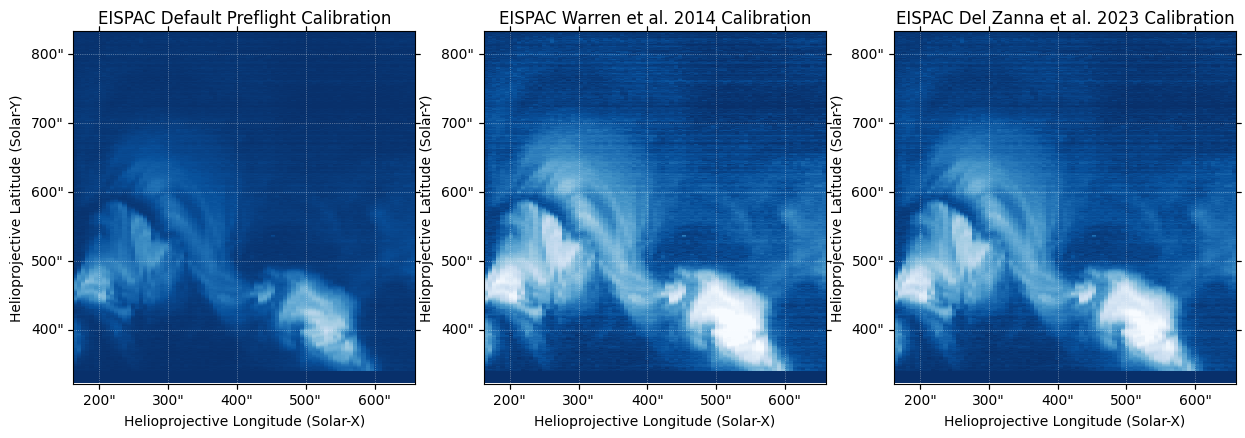

In [75]:
# Plot the original and calibrated intensity maps side by side for comparison

fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 3, 1, projection=int_262)
ax2 = fig.add_subplot(1, 3, 2, projection=int_262_2014)
ax3 = fig.add_subplot(1, 3, 3, projection=int_262_2023)

int_262.plot(axes=ax1, vmin=0,vmax=3500)
int_262_2014.plot(axes=ax2, vmin=0,vmax=3500)
int_262_2023.plot(axes=ax3, vmin=0,vmax=3500)

ax1.set_title('EISPAC Default Preflight Calibration')
ax2.set_title('EISPAC Warren et al. 2014 Calibration')
ax3.set_title('EISPAC Del Zanna et al. 2023 Calibration')

In [8]:
# Read IDL calibration results

from scipy.io import readsav
import matplotlib.pyplot as plt

In [110]:
# Read IDL calibration results from saved files

idl_no_calib = readsav('test_data/20230327_131642_fexvi_no_calib.sav').map[0][0]
idl_warren = readsav('test_data/20230327_131642_fexvi_warren.sav').map[0][0]
idl_del_zanna = readsav('test_data/20230327_131642_fexvi_del_zanna.sav').map[0][0]

Text(0.5, 1.0, 'IDL Del Zanna et al. 2023 Calibration')

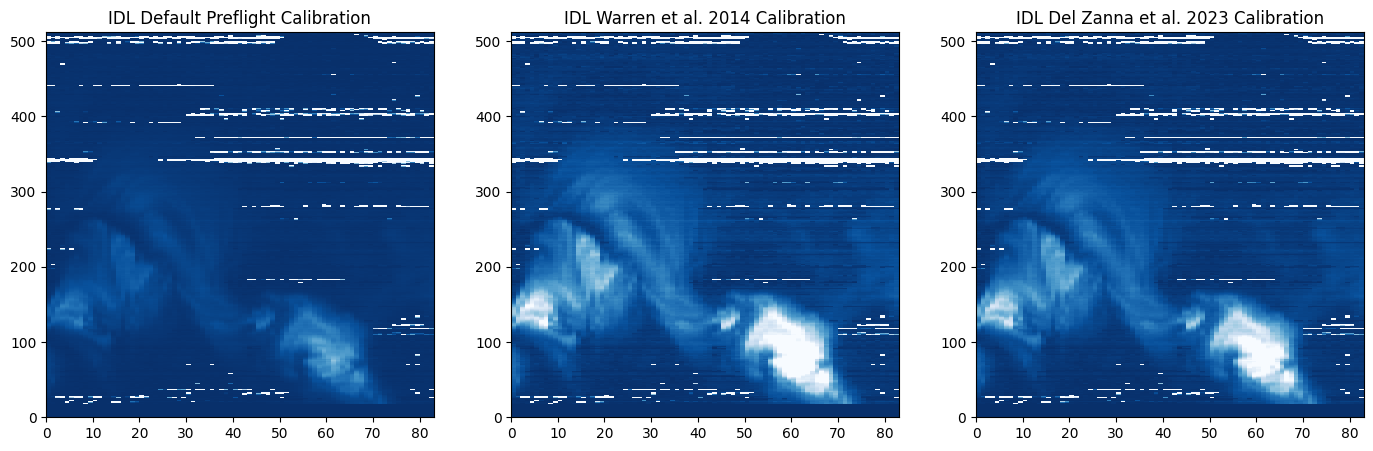

In [111]:
# Plot IDL calibration results side by side for comparison

fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(17,5))
ax1.pcolormesh(idl_no_calib, cmap='Blues_r', vmin=0,vmax=3000)
ax2.pcolormesh(idl_warren, cmap='Blues_r', vmin=0,vmax=3000)
ax3.pcolormesh(idl_del_zanna, cmap='Blues_r', vmin=0,vmax=3000)

ax1.set_title('IDL Default Preflight Calibration')
ax2.set_title('IDL Warren et al. 2014 Calibration')
ax3.set_title('IDL Del Zanna et al. 2023 Calibration')

#### Calculate the percentage difference between Calibrations in IDL vs Python

In [89]:
# Combine IDL and EISPAC calibration results into arrays for comparison

idl = np.array([idl_no_calib, idl_warren, idl_del_zanna])
eispac = np.array([int_262.data, int_262_2014.data, int_262_2023.data])

In [90]:
# Calculate the percentage difference between IDL and EISPAC calibration results

diff = (idl-eispac)/eispac*100

/var/folders/6w/c91jbrwd1k501xpqgh_czqbmvjj465/T/ipykernel_51285/3649846453.py:1: RuntimeWarning: divide by zero encountered in divide
  diff = (idl-eispac)/eispac*100


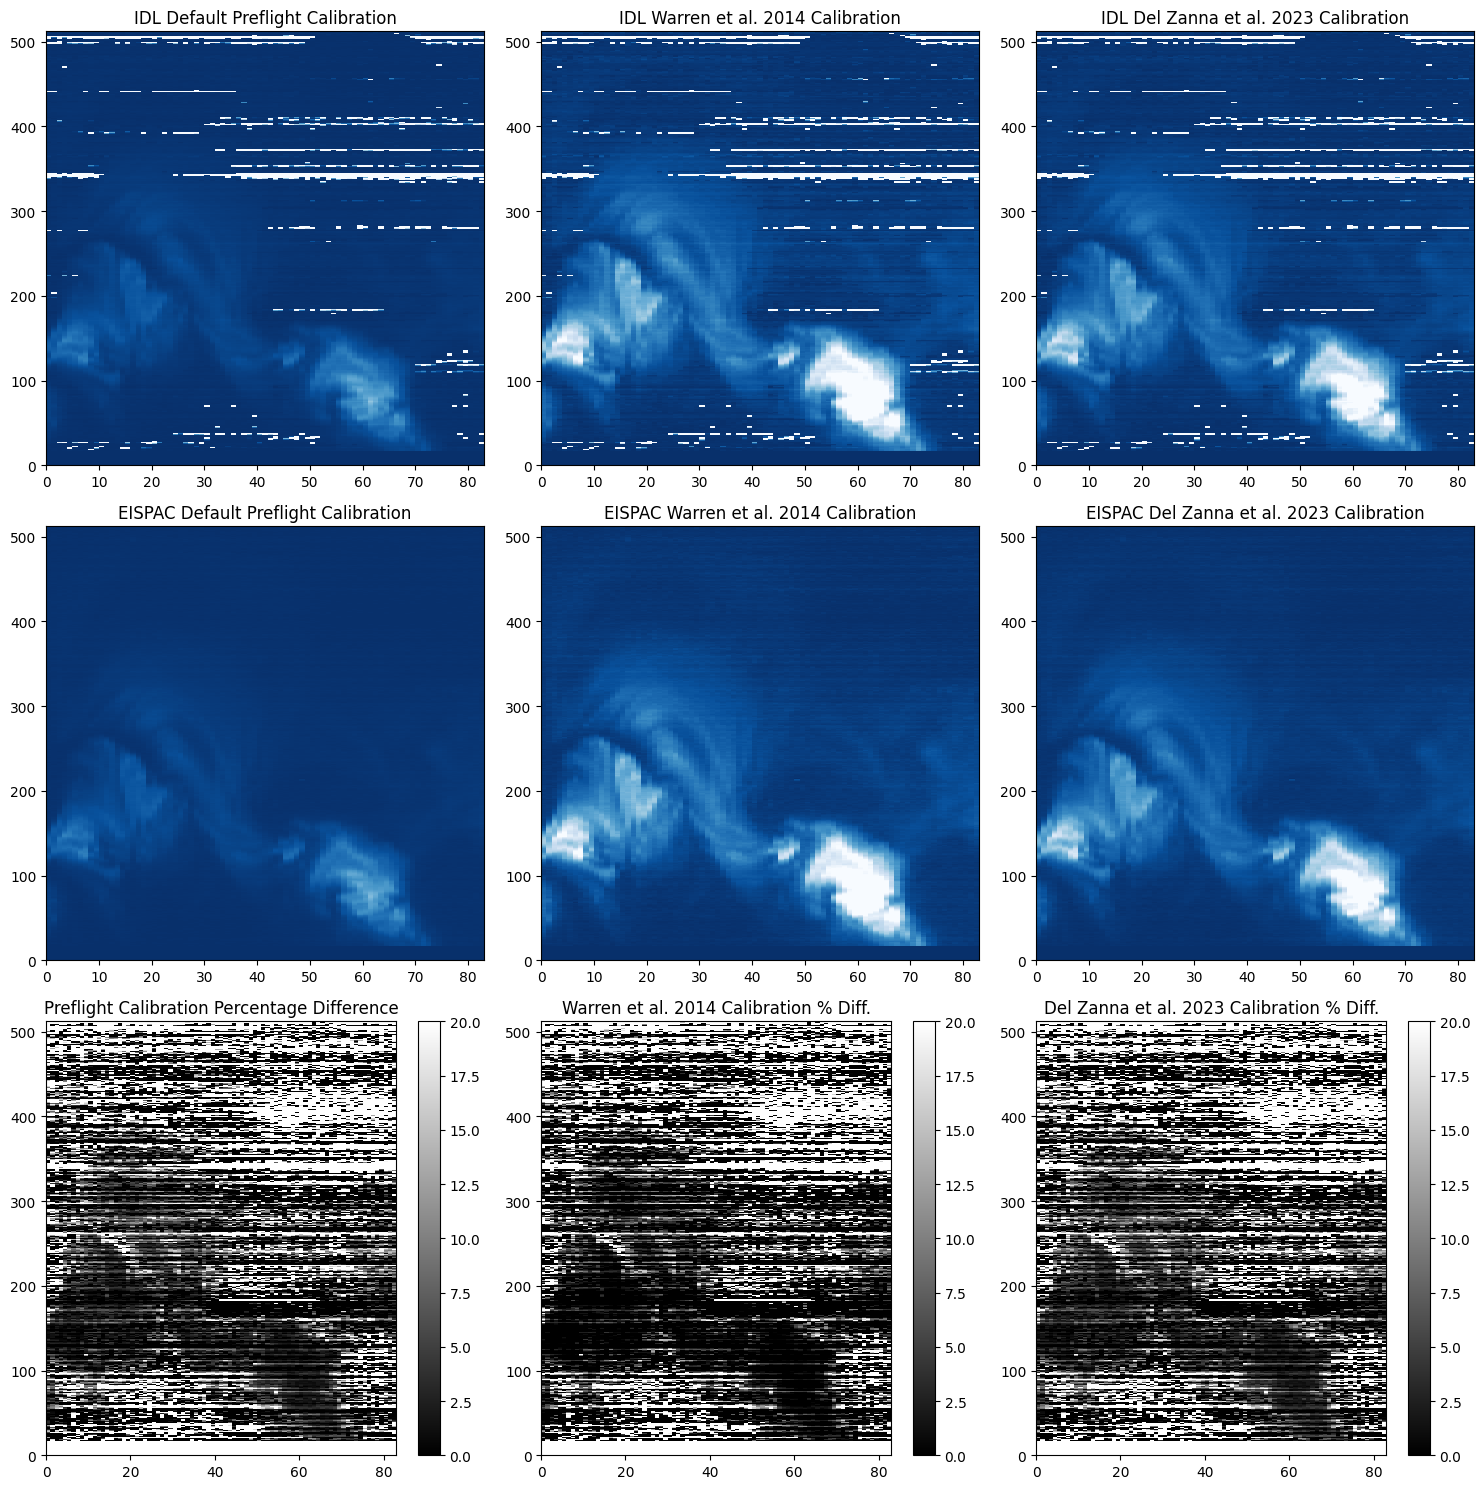

In [99]:
# Plot IDL, EISPAC, and percentage difference maps in a 3x3 grid

fig, axs = plt.subplots(3, 3, figsize=(15, 15))

axs[0, 0].pcolormesh(idl_no_calib, cmap='Blues_r', vmin=0, vmax=3000)
axs[0, 1].pcolormesh(idl_warren, cmap='Blues_r', vmin=0, vmax=3000)
axs[0, 2].pcolormesh(idl_del_zanna, cmap='Blues_r', vmin=0, vmax=3000)

axs[0, 0].set_title('IDL Default Preflight Calibration')
axs[0, 1].set_title('IDL Warren et al. 2014 Calibration')
axs[0, 2].set_title('IDL Del Zanna et al. 2023 Calibration')

axs[1, 0].pcolormesh(int_262.data, cmap='Blues_r', vmin=0, vmax=3000)
axs[1, 1].pcolormesh(int_262_2014.data, cmap='Blues_r', vmin=0, vmax=3000)
axs[1, 2].pcolormesh(int_262_2023.data, cmap='Blues_r', vmin=0, vmax=3000)

axs[1, 0].set_title('EISPAC Default Preflight Calibration')
axs[1, 1].set_title('EISPAC Warren et al. 2014 Calibration')
axs[1, 2].set_title('EISPAC Del Zanna et al. 2023 Calibration')

im6 = axs[2, 0].pcolormesh(diff[0], cmap='binary_r', vmin=0, vmax=20) # 
im7 = axs[2, 1].pcolormesh(diff[1], cmap='binary_r', vmin=0, vmax=20)
im8 = axs[2, 2].pcolormesh(diff[2], cmap='binary_r', vmin=0, vmax=20)

axs[2, 0].set_title('Preflight Calibration Percentage Difference')
axs[2, 1].set_title('Warren et al. 2014 Calibration % Diff.')
axs[2, 2].set_title('Del Zanna et al. 2023 Calibration % Diff.')

cbar1 = fig.colorbar(im6, ax=axs[2, 0])
cbar2 = fig.colorbar(im7, ax=axs[2, 1])
cbar3 = fig.colorbar(im8, ax=axs[2, 2])


plt.tight_layout()
plt.show()